In [1]:
import pickle

with open("steam_games_data_with_embeddings.pkl", "rb") as fp:
    df = pickle.load(fp)

df

,name,steam_appid,short_description,detailed_description,recommendations,genres,embedding
0,Counter-Strike,10,Play the world's number 1 online game. Engage ...,Play the world's number 1 online game. Engage ...,162799,['Action'],"[-0.022527106, -0.029677989, -0.026311869, -0...."
1,Team Fortress Classic,20,One of the most popular online games of all ti...,One of the most popular online games of all ti...,6688,['Action'],"[0.010238129, -0.030802825, -0.055642195, -0.0..."
2,Day of Defeat,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,4326,['Action'],"[-0.036401246, -0.026221575, -0.08918552, -0.0..."
3,Deathmatch Classic,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,2349,['Action'],"[-0.09361572, -0.007310211, 0.010458946, -0.09..."
4,Half-Life: Opposing Force,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,23052,['Action'],"[-0.092307486, 0.040960345, -0.041326597, 0.01..."
...,...,...,...,...,...,...,...
10434,Summer Crush,2163060,Summer Crush is a visual novel for adults wher...,Summer Crush is a visual novel for adults wher...,383,['Indie'],"[-0.058888294, -0.042121373, 0.05649996, 0.026..."
10435,Yet Another Zombie Survivors,2163330,The Horde is coming but you're ready to fight ...,You've had enough of hiding behind the barrica...,10989,"['Action', 'Casual', 'Indie', 'RPG']","[-0.012206552, -0.0018893428, -0.025645133, -0..."
10436,Tales of Spark,2165390,Tales of Spark is a Hack Slash with an Eastern...,Development PlanFollow and join usFor inquirie...,554,"['Action', 'Adventure', 'Indie', 'RPG']","[-0.07461046, 0.05776964, 0.05653439, 0.040749..."
10437,Taora : Survival,2165470,Taora is an open world survival game with uniq...,Taora is an island that is infested with zombi...,305,"['Action', 'Adventure', 'RPG', 'Simulation']","[-0.03288037, 0.021300169, -0.04909973, 0.0219..."


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

X = np.stack(df["embedding"].to_numpy())
labels = df["genres"]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

X.shape

(10439, 384)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(y_test)}")


Train samples: 7829
Test samples: 2610


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

base_classifier = LogisticRegression()
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import jaccard_score, make_scorer

result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multicla

np.float64(0.7444031414746561)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

base_classifier = RandomForestClassifier(class_weight="balanced")
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)

result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclas

In [ ]:
from sklearn.svm import SVC

base_classifier = SVC()
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)

result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(


/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(


Acc: 0.12873563218390804, Jaccard: 0.755835286739527


/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(


Acc: 0.12873563218390804, Jaccard: 0.755835286739527


Exception ignored in: <function ResourceTracker.__del__ at 0x7f33f048eca0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe671b96ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe671b96ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

In [ ]:
from sklearn.multioutput import ClassifierChain

valid_labels = (y_train.sum(axis=0) > 0) & (y_train.sum(axis=0) < y_train.shape[0])
y_train_filtered = y_train[:, valid_labels]
y_test_filtered = y_test[:, valid_labels]

base_classifier = LogisticRegression(solver="liblinear")
clf = ClassifierChain(base_classifier)
result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

,estimator,LogisticRegre...r='liblinear')
,order,None
,cv,None
,chain_method,'predict'
,random_state,None
,verbose,False
,base_estimator,'deprecated'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [58]:
# PyTorch multilabel classifier (MLP) training and evaluation
import math
import numpy as np

# Optional: if sklearn metrics not in scope (cell re-run independently)
try:
    from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
except Exception:
    pass

# 1) Resolve labels: use filtered labels if they exist (to avoid constant columns), else fallback to full labels
try:
    y_tr = y_train_filtered
    y_te = y_test_filtered
except NameError:
    y_tr = y_train
    y_te = y_test

num_features = int(X_train.shape[1])
num_labels = int(y_tr.shape[1])

# 2) Build PyTorch Dataset/DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Tensors
X_train_t = torch.from_numpy(X_train).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_tr).float()
y_test_t = torch.from_numpy(y_te).float()

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# 3) Model (now supports arbitrary hidden layers)
class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_layers=(256, 128), dropout: float = 0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, out_dim))  # logits for BCEWithLogitsLoss
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 4) Loss (with class imbalance handling via pos_weight)
# pos_weight = (N - pos) / pos; add epsilon to avoid div-by-zero
with torch.no_grad():
    pos = y_train_t.sum(dim=0)
    neg = y_train_t.shape[0] - pos
    eps = 1e-6
    pos_weight = (neg / (pos + eps)).clamp(min=0.0, max=1e6)

# 5) Train loop
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(num_features, num_labels, hidden_layers=(64,), dropout=0.5).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

epochs = 50  # increase for better results if time allows

def evaluate(model, loader, threshold: float = 0.5):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_targets.append(yb.cpu())
    logits = torch.cat(all_logits, dim=0)
    targets = torch.cat(all_targets, dim=0)
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    return preds.numpy().astype(int), targets.numpy().astype(int)

best_val = math.inf
train_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(float(train_loss))

    # simple validation loss for scheduling
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_running_loss += loss.item() * xb.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(float(val_loss))

    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d}/{epochs} - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}")

# 6) Evaluation metrics on test set
# Use same metrics as earlier cells for apples-to-apples comparison
pred_np, tgt_np = evaluate(model, val_loader, threshold=0.5)

acc = accuracy_score(tgt_np, pred_np)
jaccard = jaccard_score(tgt_np, pred_np, average="samples")
hamming = hamming_loss(tgt_np, pred_np)

print(f"[PyTorch MLP] Acc: {acc:.4f}, Jaccard: {jaccard:.4f}, Hamming: {hamming:.4f}")

Epoch 01/50 - train_loss: 0.6304  val_loss: 0.6226
Epoch 02/50 - train_loss: 0.6136  val_loss: 0.5983
Epoch 03/50 - train_loss: 0.5875  val_loss: 0.5683
Epoch 04/50 - train_loss: 0.5618  val_loss: 0.5444
Epoch 05/50 - train_loss: 0.5454  val_loss: 0.5301
Epoch 06/50 - train_loss: 0.5353  val_loss: 0.5214
Epoch 04/50 - train_loss: 0.5618  val_loss: 0.5444
Epoch 05/50 - train_loss: 0.5454  val_loss: 0.5301
Epoch 06/50 - train_loss: 0.5353  val_loss: 0.5214
Epoch 07/50 - train_loss: 0.5300  val_loss: 0.5161
Epoch 08/50 - train_loss: 0.5242  val_loss: 0.5120
Epoch 09/50 - train_loss: 0.5199  val_loss: 0.5086
Epoch 07/50 - train_loss: 0.5300  val_loss: 0.5161
Epoch 08/50 - train_loss: 0.5242  val_loss: 0.5120
Epoch 09/50 - train_loss: 0.5199  val_loss: 0.5086
Epoch 10/50 - train_loss: 0.5158  val_loss: 0.5053
Epoch 11/50 - train_loss: 0.5130  val_loss: 0.5025
Epoch 12/50 - train_loss: 0.5108  val_loss: 0.5004
Epoch 10/50 - train_loss: 0.5158  val_loss: 0.5053
Epoch 11/50 - train_loss: 0.513

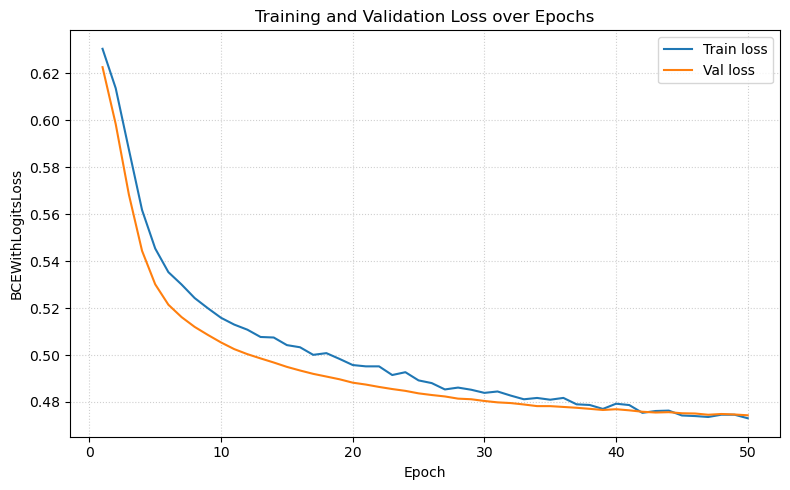

In [59]:
# Plot losses over epochs
import matplotlib.pyplot as plt

epochs_axis = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs_axis, train_losses, label="Train loss")
plt.plot(epochs_axis, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("Training and Validation Loss over Epochs")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()